In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
from dataset import StoneDataset
import seaborn as sns
import random
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import pandas as pd

Text(0.5, 1.0, 'Class Distribution in Training Set')

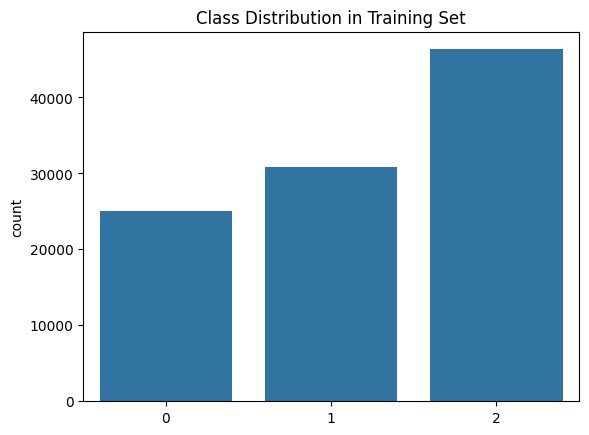

In [7]:
train_data = StoneDataset(root="./dataset/train_val", split="train", transforms=transforms.ToTensor())

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

labels = train_data.labels
sns.countplot(x=labels)
plt.title("Class Distribution in Training Set")

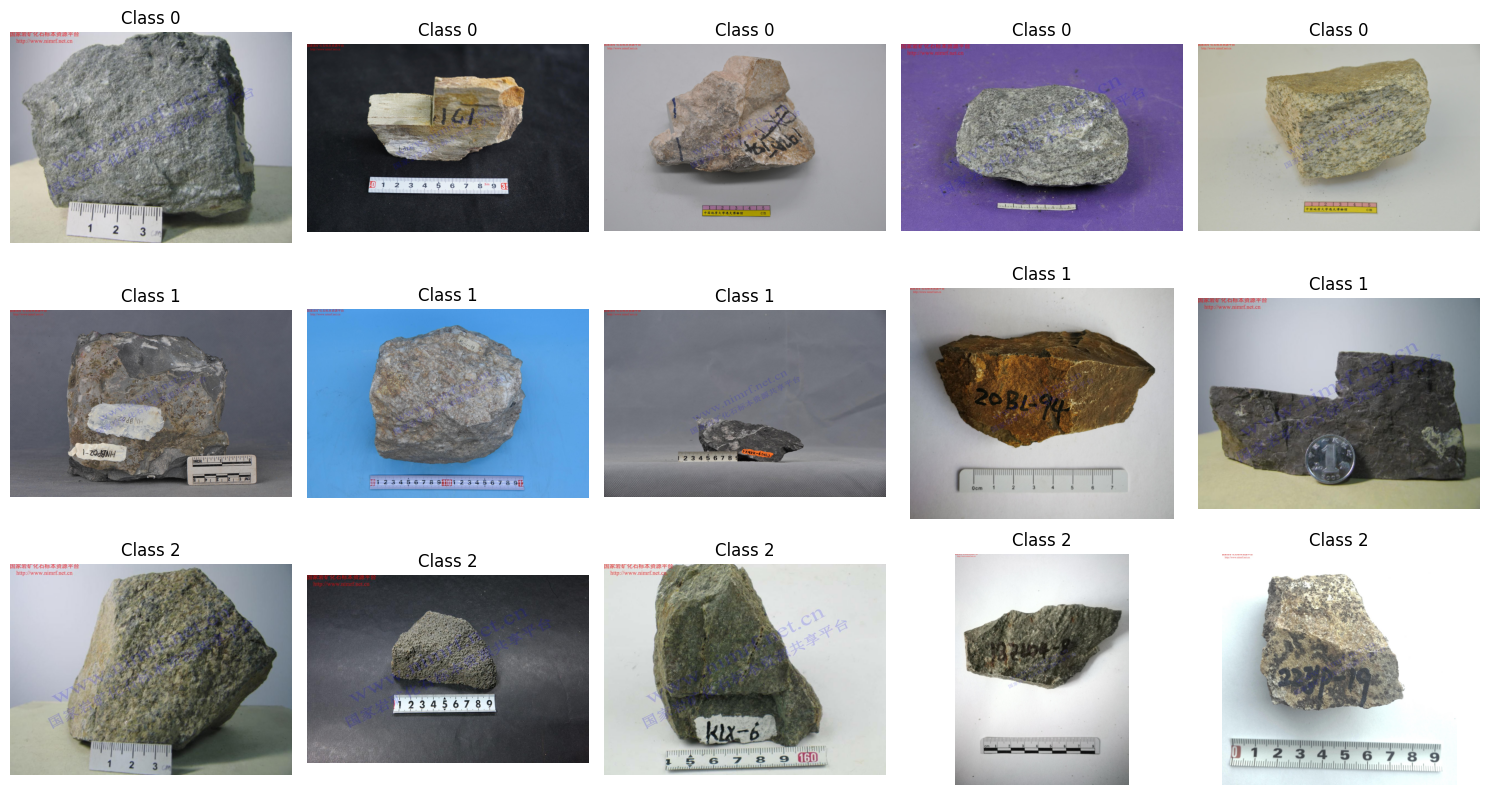

In [8]:
class_indices = {0: [], 1: [], 2: []}
for idx, label in enumerate(train_data.labels):
    class_indices[label].append(idx)

num_samples_per_class = 5
selected_indices = {}
for cls in class_indices:
    if len(class_indices[cls]) >= num_samples_per_class:
        selected_indices[cls] = random.sample(class_indices[cls], num_samples_per_class)
    else:
        selected_indices[cls] = class_indices[cls]

# 直接转换张量为 PIL 图像（无需反归一化）
def tensor_to_pil(tensor):
    return transforms.ToPILImage()(tensor.cpu().clone().squeeze(0))

# 显示图像
fig, axes = plt.subplots(len(selected_indices), num_samples_per_class, figsize=(15, 8))
for cls_idx, cls in enumerate(selected_indices):
    for i, idx in enumerate(selected_indices[cls]):
        img, label = train_data[idx]
        img_pil = tensor_to_pil(img)  # 直接转换
        ax = axes[cls_idx, i]
        ax.imshow(img_pil)
        ax.axis('off')
        ax.set_title(f'Class {cls}')
plt.tight_layout()
plt.show()

In [9]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 创建DataLoader
batch_size = 128
train_loader = DataLoader(
    StoneDataset(root="./dataset/train_val", split="train", transforms=train_transform),
    batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    StoneDataset(root="./dataset/train_val", split="val", transforms=val_transform),
    batch_size=batch_size, shuffle=False, num_workers=4
)

In [18]:
# def build_efficientnet(num_classes=3, pretrained=True):
#     weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
#     model = efficientnet_b0(weights=weights)
#     # 调整分类器
#     in_features = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(in_features, num_classes)
#     return model

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def build_efficientnet(num_classes=3, pretrained=True, local_weight_path=None):
    if pretrained and local_weight_path:
        # 加载无预训练模型
        model = efficientnet_b0(weights=None)
        state_dict = torch.load(local_weight_path, map_location='cpu')
        model.load_state_dict(state_dict)
    else:
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        model = efficientnet_b0(weights=weights)

    # 修改分类器头部
    in_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(in_features, num_classes)

    return model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_labels = train_data.labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    model = model.to(device)
    best_acc = 0.0
    train_losses, val_losses, val_accs,val_f1 = [], [], [],[]
    
    for epoch in range(num_epochs):
        # 训练阶段
        print(epoch)
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # 验证阶段
        val_loss, val_acc, val_f1_score = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_f1.append(val_f1_score)
        val_accs.append(val_acc)
        
        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%} | Val F1: {val_f1_score:.4f}')  # 新增 F1
    
    history = {'train_loss': train_losses, 'val_loss': val_losses, 'val_acc': val_accs, 'val_f1': val_f1}
    return model, history

In [13]:
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / len(data_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1

In [20]:
local_weight_path = "efficientnet_b0_rwightman-7f5810bc.pth"
model = build_efficientnet(num_classes=3, pretrained=True, local_weight_path=local_weight_path)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

/tmp/ipykernel_47704/2612212995.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(local_weight_path, map_location='cpu')


In [21]:
# model = build_efficientnet(num_classes=3, pretrained=False)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [22]:
# 训练模型
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50
)

0
Epoch 1/50 | Train Loss: 0.8118 | Val Loss: 0.7124 | Val Acc: 68.00% | Val F1: 0.6810
1
Epoch 2/50 | Train Loss: 0.7300 | Val Loss: 0.6717 | Val Acc: 70.81% | Val F1: 0.7087
2
Epoch 3/50 | Train Loss: 0.6889 | Val Loss: 0.6354 | Val Acc: 72.61% | Val F1: 0.7273
3
Epoch 4/50 | Train Loss: 0.6593 | Val Loss: 0.6161 | Val Acc: 73.40% | Val F1: 0.7339
4
Epoch 5/50 | Train Loss: 0.6372 | Val Loss: 0.6036 | Val Acc: 74.87% | Val F1: 0.7490
5
Epoch 6/50 | Train Loss: 0.6178 | Val Loss: 0.6000 | Val Acc: 75.35% | Val F1: 0.7543
6
Epoch 7/50 | Train Loss: 0.5981 | Val Loss: 0.5951 | Val Acc: 75.36% | Val F1: 0.7542
7
Epoch 8/50 | Train Loss: 0.5780 | Val Loss: 0.5938 | Val Acc: 75.51% | Val F1: 0.7557
8
Epoch 9/50 | Train Loss: 0.5634 | Val Loss: 0.6039 | Val Acc: 75.26% | Val F1: 0.7517
9
Epoch 10/50 | Train Loss: 0.5453 | Val Loss: 0.5933 | Val Acc: 76.07% | Val F1: 0.7604
10
Epoch 11/50 | Train Loss: 0.5372 | Val Loss: 0.5814 | Val Acc: 76.17% | Val F1: 0.7622
11
Epoch 12/50 | Train Loss: 

In [25]:
# 训练模型
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50
)

0
Epoch 1/50 | Train Loss: 0.9993 | Val Loss: 0.9615 | Val Acc: 50.75% | Val F1: 0.4926
1
Epoch 2/50 | Train Loss: 0.9650 | Val Loss: 0.9077 | Val Acc: 55.11% | Val F1: 0.5495
2
Epoch 3/50 | Train Loss: 0.9411 | Val Loss: 0.8849 | Val Acc: 56.27% | Val F1: 0.5588
3
Epoch 4/50 | Train Loss: 0.9222 | Val Loss: 0.8580 | Val Acc: 58.03% | Val F1: 0.5793
4
Epoch 5/50 | Train Loss: 0.9049 | Val Loss: 0.8616 | Val Acc: 58.38% | Val F1: 0.5821
5
Epoch 6/50 | Train Loss: 0.8905 | Val Loss: 0.8336 | Val Acc: 60.60% | Val F1: 0.6053
6
Epoch 7/50 | Train Loss: 0.8783 | Val Loss: 0.8172 | Val Acc: 61.02% | Val F1: 0.6112
7
Epoch 8/50 | Train Loss: 0.8687 | Val Loss: 0.8178 | Val Acc: 61.16% | Val F1: 0.6096
8
Epoch 9/50 | Train Loss: 0.8585 | Val Loss: 0.7958 | Val Acc: 62.19% | Val F1: 0.6224
9
Epoch 10/50 | Train Loss: 0.8511 | Val Loss: 0.7928 | Val Acc: 62.77% | Val F1: 0.6282
10
Epoch 11/50 | Train Loss: 0.8419 | Val Loss: 0.7811 | Val Acc: 63.75% | Val F1: 0.6369
11
Epoch 12/50 | Train Loss: 

In [23]:
def predict(model, test_loader):
    model.eval()
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            filenames.extend(list(paths))
            predictions.extend(preds.cpu().numpy())
    return filenames, predictions

test_loader = DataLoader(
    StoneDataset(root="./dataset/test", split="test", transforms=val_transform),
    batch_size=batch_size, shuffle=False
)

filenames, preds = predict(model, test_loader)

In [24]:
df = pd.DataFrame({"filename": filenames, "label": preds})
df.to_csv("submission2new.csv", index=False)

In [27]:
# df = pd.DataFrame({"filename": filenames, "label": preds})
# df.to_csv("submission2.csv", index=False)

In [28]:
import matplotlib.pyplot as plt
def plot_training_log():
    epochs = list(range(1, 51))  # 共50个epoch

    train_loss = [
        0.9993, 0.9650, 0.9411, 0.9222, 0.9049, 0.8905, 0.8783, 0.8687, 0.8585, 0.8511,
        0.8419, 0.8338, 0.8253, 0.8171, 0.8105, 0.8053, 0.8005, 0.7954, 0.7887, 0.7827,
        0.7775, 0.7723, 0.7719, 0.7641, 0.7605, 0.7559, 0.7512, 0.7461, 0.7416, 0.7401,
        0.7332, 0.7325, 0.7285, 0.7233, 0.7187, 0.7159, 0.7122, 0.7115, 0.7050, 0.7044,
        0.6956, 0.6950, 0.6927, 0.6898, 0.6864, 0.6829, 0.6776, 0.6773, 0.6767, 0.6691
    ]
    
    val_loss = [
        0.9615, 0.9077, 0.8849, 0.8580, 0.8616, 0.8336, 0.8172, 0.8178, 0.7958, 0.7928,
        0.7811, 0.7634, 0.7634, 0.7573, 0.7486, 0.7391, 0.7634, 0.7432, 0.7431, 0.7237,
        0.7172, 0.7107, 0.7103, 0.7032, 0.7003, 0.7172, 0.6990, 0.6934, 0.6845, 0.6904,
        0.6852, 0.6778, 0.6799, 0.6703, 0.6674, 0.6651, 0.6709, 0.6573, 0.6576, 0.6568,
        0.6724, 0.6593, 0.6510, 0.6523, 0.6518, 0.6406, 0.6432, 0.6517, 0.6435, 0.6414
    ]

    plt.figure(figsize=(12, 7))

    plt.plot(epochs, train_loss, label='Train Loss', color='purple', linewidth=2)
    plt.plot(epochs, val_loss, label='Val Loss', color='red', linewidth=2)
    plt.title('Efficient Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


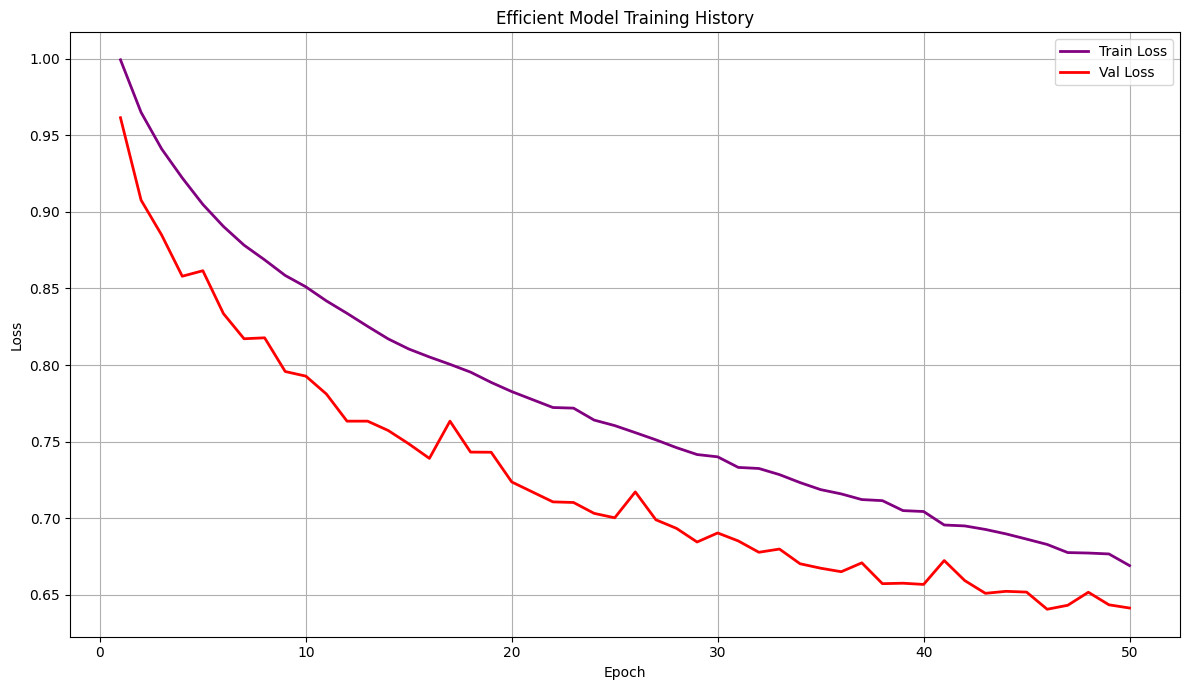

In [29]:
plot_training_log()